# **First** autoencoder

This notebook contains three phaseinference methods: PCA, a fully-linear autoencoder (which is equivalent, but slightly worse than PCA) and finally a CIRCULAR-autoencoder. 

TO ADD:
-add batch size!

## Importing data

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from sklearn.decomposition import PCA

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt

#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

Real DATA

In [2]:
bigData = pd.read_csv("/Users/salati/Documents/CODE/AE2/DATA/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
PeriodicDataStandard=PeriodicData.sub(PeriodicData.mean(1), axis=0).div(PeriodicData.std(1), axis=0)


In [3]:
#DATA=torch.tensor(PeriodicData.values)
DATA=torch.tensor(PeriodicDataStandard.values)

#E=np.array(PeriodicData.values)
E=np.array(PeriodicDataStandard.values)
DATA=DATA.float()


true_phases=pd.read_csv("/Users/salati/Documents/CODE/AE2/DATA/true_phi.txt",sep=" ")
true_phases=np.array(true_phases.values)
true_phases=true_phases[:,0]

Simulated DATA

In [ ]:
N_Samples=56
N_PeriodicGenes=12
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes
NoiseSigma=0.7

#E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes , Means=False, NoiseSigma=NoiseSigma )

DATA=torch.from_numpy(E)
DATA=DATA.float()

In [4]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

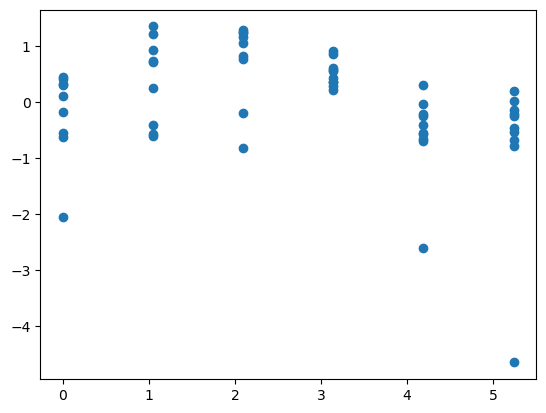

In [5]:
plt.plot(true_phases,DATA[3,:], 'o')

## PCA

In [6]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [7]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  -5.898059818321144e-17


In [8]:
pca_points=pca.fit_transform(Et)

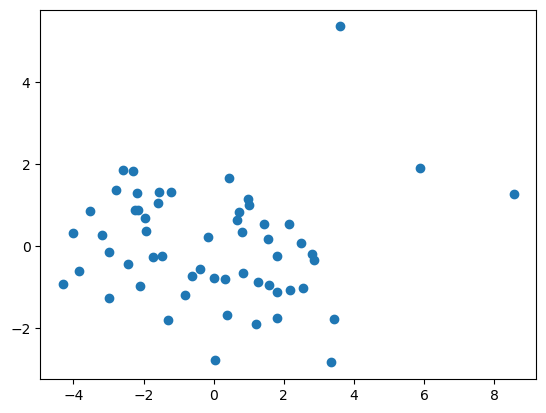

In [9]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [10]:
from DATA_generator import *
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])
PCAshifted_phi,madPCA=optimal_shift(PCA_phi, true_phases)
madPCA

0.34751751567378264

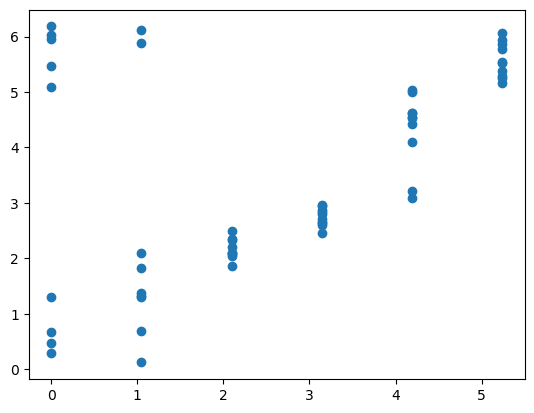

In [11]:
plt.plot(true_phases,PCAshifted_phi, 'o')

## Torch Linear

### Setting the network

In [12]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()

Here we can choose how to initialize the weights, random or wioth the PCA base

In [13]:
#defining by hand and random initializing the weights, we can also

#encoder_w=torch.randn((2, N_Genes), requires_grad=True)
encoder_w=PCA_tensor.clone().requires_grad_(True)

#decoder_w=torch.randn((N_Genes, 2), requires_grad=True)
decoder_w=PCA_tensor.transpose(0,1).clone().requires_grad_(True)

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [14]:
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
#optimizer=torch.optim.Adam([encoder_w,decoder_w], lr=0.0001)
optimizer = torch.optim.Adam([encoder_w,decoder_w], lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Training cycle

In [15]:
#recon= reconstruction of the input
num_epochs=2000
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    #print("input ",input.shape)
    hidden=F.linear( input, encoder_w)
    #print("hidden ",hidden)
    recon=F.linear( hidden, decoder_w)
    #print('recon ' ,recon)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 50 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 0.05038977041840553
epoch  50 Loss 0.05830012634396553
epoch  100 Loss 0.05847476050257683
epoch  150 Loss 0.05852128565311432
epoch  200 Loss 0.05853809788823128
epoch  250 Loss 0.05854574963450432
epoch  300 Loss 0.058550432324409485
epoch  350 Loss 0.05855420231819153
epoch  400 Loss 0.058557529002428055
epoch  450 Loss 0.058560628443956375
epoch  500 Loss 0.05856366083025932
epoch  550 Loss 0.05856666341423988
epoch  600 Loss 0.058569762855768204
epoch  650 Loss 0.05857256054878235
epoch  700 Loss 0.058575376868247986
epoch  750 Loss 0.05857820808887482
epoch  800 Loss 0.05858081951737404
epoch  850 Loss 0.058583348989486694
epoch  900 Loss 0.05858622491359711
epoch  950 Loss 0.05858849361538887
epoch  1000 Loss 0.05859106406569481
epoch  1050 Loss 0.058593276888132095
epoch  1100 Loss 0.0585956908762455
epoch  1150 Loss 0.05859780311584473
epoch  1200 Loss 0.058600082993507385
epoch  1250 Loss 0.05860261619091034
epoch  1300 Loss 0.058604493737220764
epoch  1350 Loss

In [16]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
    input=DATA[:,sample]
    
    hidden=F.linear( input, encoder_w).detach().numpy()
    NNphases[sample,:]=hidden
    
    #added this line to compare with the circular model, thisline block the convergence

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

### Plots

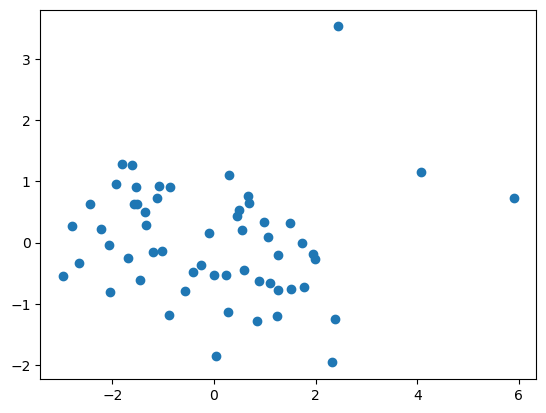

In [17]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [18]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )
NNshifted_phi,madNN=optimal_shift(inf_phases, true_phases)
madNN

0.3385907091577849

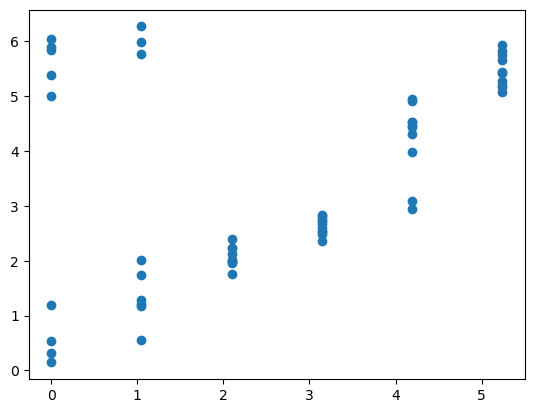

In [19]:
plt.plot(true_phases,NNshifted_phi,'o')

## Adding the "circular" activation function

### Setting the network

In [20]:
#defining by hand and random initializing the weights, we can also use the PCA values to initialise

#encoderC_w=torch.randn((2, N_Genes), requires_grad=True)
#decoderC_w=torch.randn((N_Genes, 2), requires_grad=True)

encoderC_w=PCA_tensor.clone().requires_grad_(True)
decoderC_w=PCA_tensor.transpose(0,1).clone().requires_grad_(True)

In [21]:
criterionC= nn.MSELoss()
optimizerC = torch.optim.Adam([encoderC_w,decoderC_w], lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)

In [22]:
num_epochs=30000

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
   
    hidden=F.linear( input, encoderC_w)
    #print("hidden ",hidden)
    hiddenC=hidden/torch.linalg.norm(hidden)
    #print("hiddenC ",hiddenC)
    recon=F.linear( hiddenC, decoderC_w)
    #print('recon ' ,recon)
    loss=criterionC(recon,input)

  optimizerC.zero_grad()
  loss.backward()
  optimizerC.step()

  if loss.item() < 0.0005 :
    break
  if (epoch % 500 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 0.6296353936195374
epoch  500 Loss 0.5388772487640381
epoch  1000 Loss 0.4534622132778168
epoch  1500 Loss 0.3760467767715454
epoch  2000 Loss 0.30764925479888916
epoch  2500 Loss 0.24826039373874664
epoch  3000 Loss 0.19740641117095947
epoch  3500 Loss 0.15444283187389374
epoch  4000 Loss 0.11867433041334152
epoch  4500 Loss 0.08939238637685776
epoch  5000 Loss 0.06588149815797806
epoch  5500 Loss 0.0474187470972538
epoch  6000 Loss 0.03327321633696556
epoch  6500 Loss 0.022712064906954765
epoch  7000 Loss 0.015024232678115368
epoch  7500 Loss 0.009563375264406204
epoch  8000 Loss 0.005788274575024843
epoch  8500 Loss 0.003274463815614581
epoch  9000 Loss 0.0016914838925004005
epoch  9500 Loss 0.0007723296876065433


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [23]:
NNphasesC=np.zeros((N_Samples,2))

for sample in range(N_Samples):#range(N_Samples):
    input=DATA[:,sample]
    #print(input)
    
    hidden=F.linear( input, encoderC_w)
    #print("hidden ",hidden)
    hiddenC=hidden/torch.linalg.norm(hidden)
    #print("hiddenC ",hiddenC.detach().numpy() )
    NNphasesC[sample,:]=hiddenC.detach().numpy()
    

### Plots

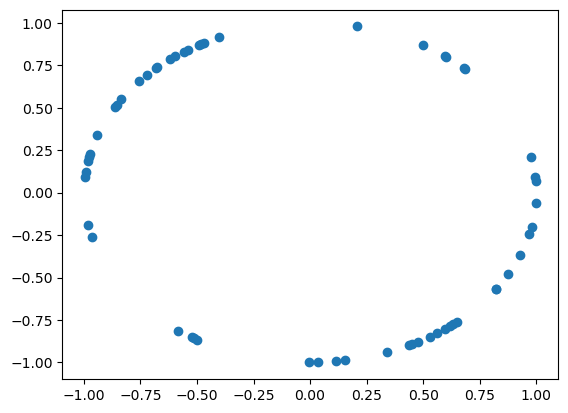

In [24]:
plt.plot(NNphasesC[:,0], NNphasesC[:,1],'o')

In [25]:
inf_phasesC=np.arctan2( NNphasesC[:,0],NNphasesC[:,1] )

NNshifted_phiC,madNNC=optimal_shift(inf_phasesC, true_phases)

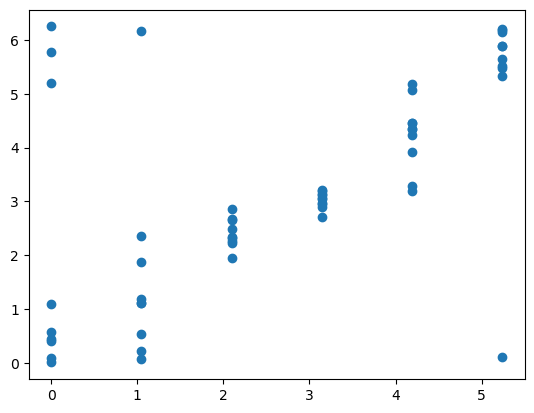

In [26]:
plt.plot(true_phases,NNshifted_phiC,'o')

Outliers really impacat this way of mesuring the goodness of the fit

In [27]:
print('PCA ', sum((true_phases-PCAshifted_phi)**2) )
print('Linear NN ', sum((true_phases-NNshifted_phi)**2) )
print('Circular NN ', sum((true_phases-NNshifted_phiC)**2) )

PCA  228.80398614752872
Linear NN  245.31385819330058
Circular NN  167.86937092059986


MAD seems more appropriate


In [28]:
print('PCA ', madPCA )
print('Linear NN ', madNN )
print('circular NN ', madNNC )

PCA  0.34751751567378264
Linear NN  0.3385907091577849
circular NN  0.28706476036636097
